# Regridding using Land/Sea masks

#### Nomenclature used here:
- target grid / target dataset: this is the common grid that all data should be on after regridding. In this case, the NCAR 100km grid.
- source dataset: the data we want to regrid
- regridded dataset: the source data after regridding
- mask: an array of 1's and 0s, where 1 represents locations that have real data values and 0 represents locations that are NaN.

In previous notebook explorations we determined that during regridding, we can apply the exact same NaN areas found in our target grid to the regridded dataset output. The most consistent way to do this is to add a `mask` variable to the both the target grid dataset and source dataset used in the `xESMF.Regridder()` function. If target and source datasets are already on the same grid (and therfore share locations for NaN values), this will prevent the regridder from using NaNs as actual data values in the regridding math. If target and source datasets are on different grids, the NaN values of the target grid will "overrule" any values in the source dataset. (This is especially useful in cases where 0 is used as the NaN value in the source datasets.)

### Setup:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
# define coastal area used in plotting
lat_slice = slice(50, 65)
lon_slice = slice(-150, -135)

In [3]:
# function to load dataset and apply longitude correction; returns dataset for first time slice
def load_ds(fp):
    # open dataset and apply longitude correction 
    ds = xr.open_dataset(fp)
    lon_enc = ds["lon"].encoding
    lon_attrs = ds["lon"].attrs
    # subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
    ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
    ds["lon"].encoding = lon_enc
    ds["lon"].attrs = lon_attrs
    # sort
    ds = ds.sortby(ds.lon, ascending=True)
    # get first time slice
    ds = ds.isel(time=[0])
    return ds

# function to plot target, target mask, source, source mask, and regridded datasets side by side
def regrid_plots(target_ds, target_var_id, src_ds, src_var_id, regrid_ds, lat_slice, lon_slice):
    fig, ax = plt.subplots(1, 5, figsize=(25, 4))
    vmin, vmax = src_ds[src_var_id].sel(lat=lat_slice, lon=lon_slice).min(), src_ds[src_var_id].sel(lat=lat_slice, lon=lon_slice).max()

    target_ds[target_var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[0])
    target_ds['mask'].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[1])
    src_ds[src_var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[2], vmin=vmin, vmax=vmax)
    src_ds['mask'].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[3])    
    regrid_ds[src_var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[4], vmin=vmin, vmax=vmax)

    ax[0].set_title("target grid")
    ax[1].set_title("target grid mask")
    ax[2].set_title("source data")
    ax[3].set_title("source data mask")
    ax[4].set_title("regridded data")

    for a in range(len(ax)):
        ax[a].set_xlabel("")
        ax[a].set_ylabel("")

    plt.show()

# function to add a NaN mask variable to the dataset
def add_mask(ds, var_id):
    # create the mask from the first time slice, using 1 for values and 0 for NaNs
    ds["mask"] = xr.where(~np.isnan(ds[var_id]), 1, 0).isel(time=0)
    return ds

# function to mask, regrid, and plot
def regrid_and_plot(target_ds, src_ds, src_var_id, lat_slice, lon_slice):
    src_ds = add_mask(src_ds, src_var_id)
    target_ds = add_mask(target_ds, target_var_id)
    regridder = xe.Regridder(src_ds, target_ds, "bilinear", unmapped_to_nan=True)
    regrid_ds = regridder(src_ds, keep_attrs=True)
    regrid_plots(target_ds, target_var_id, src_ds, src_var_id, regrid_ds, lat_slice, lon_slice)

# function to mask, regrid, and plot
def regrid_extrap_and_plot(target_ds, src_ds, src_var_id, lat_slice, lon_slice):
    src_ds = add_mask(src_ds, src_var_id)
    target_ds = add_mask(target_ds, target_var_id)
    regridder = xe.Regridder(src_ds, target_ds, "bilinear", extrap_method="nearest_s2d", unmapped_to_nan=True)
    regrid_ds = regridder(src_ds, keep_attrs=True)
    regrid_plots(target_ds, target_var_id, src_ds, src_var_id, regrid_ds, lat_slice, lon_slice)

## Land Masks:

Let's load an NCAR target grid from a land-only variable `mrro`. Then we can plot the data elements of the `xESMF.Regridder()` function to get a sense of what is actually happening with the masks in different grid scenarios.

In [4]:
target_var_id = "mrro"
target_ds = load_ds('/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/Lmon/mrro/gn/v20190815/mrro_Lmon_CESM2-WACCM_ssp370_r1i1p1f1_gn_201501-206412.nc')

In [5]:
# dict of models/demo files for different scenarios
# we assume that all files for a given land-only variable will have an identical land mask
# all demo files here are "mrro" variables

# Scenario 1: NaN is NaN in source data (identical to target grid)
nan_target = {
'CESM2-WACCM':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/mrro/gn/v20200702/mrro_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
}

# Scenario 2: NaN is 0 in source data (non-target grid)
nan_zero = {
'GFDL-ESM4':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp245/r1i1p1f1/day/mrro/gr1/v20180701/mrro_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20550101-20741231.nc',
'TaiESM1':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/ssp126/r1i1p1f1/Lmon/mrro/gn/v20201124/mrro_Lmon_TaiESM1_ssp126_r1i1p1f1_gn_201501-210012.nc',
'NorESM2-MM':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ssp126/r1i1p1f1/Lmon/mrro/gn/v20191108/mrro_Lmon_NorESM2-MM_ssp126_r1i1p1f1_gn_201502-202012.nc',
}

# Scenario 3: NaN is NaN in source data (non-target grid)
nan_nan = {
'CNRM-CM6-1-HR':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1-HR/ssp126/r1i1p1f2/Lmon/mrro/gr/v20200127/mrro_Lmon_CNRM-CM6-1-HR_ssp126_r1i1p1f2_gr_201501-210012.nc',
'MPI-ESM1-2-HR':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp126/r1i1p1f1/Lmon/mrro/gn/v20190710/mrro_Lmon_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_201501-201912.nc',
'EC-Earth3-Veg':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp126/r1i1p1f1/Lmon/mrro/gr/v20221112/mrro_Lmon_EC-Earth3-Veg_ssp126_r1i1p1f1_gr_201501-201512.nc',
'MIROC6':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp126/r1i1p1f1/day/mrro/gn/v20191016/mrro_day_MIROC6_ssp126_r1i1p1f1_gn_20150101-20241231.nc',
'HadGEM3-GC31-LL':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp126/r1i1p1f3/Lmon/mrro/gn/v20200114/mrro_Lmon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_201501-204912.nc',
'MPI-ESM1-2-LR':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp126/r1i1p1f1/day/mrro/gn/v20190710/mrro_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_20150101-20341231.nc',
'KACE-1-0-G':'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NIMS-KMA/KACE-1-0-G/ssp126/r1i1p1f1/Lmon/mrro/gr/v20191011/mrro_Lmon_KACE-1-0-G_ssp126_r1i1p1f1_gr_201501-210012.nc',
}

### Scenario 1: 
Source datasets already using the target grid. NaN values are identical in regridded output. 

**This is safe and has a predictable output.**

CESM2-WACCM:


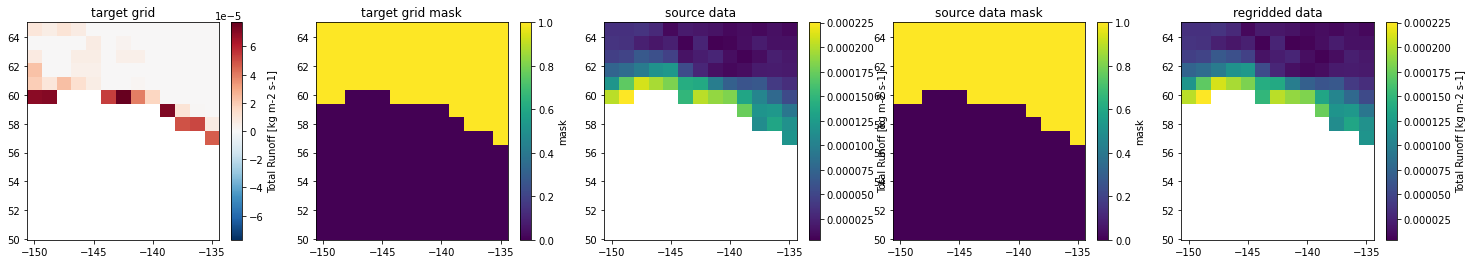

In [6]:
for model in nan_target.keys():
    src_ds = load_ds(nan_target[model])
    print(f"{model}:")
    regrid_and_plot(target_ds, src_ds, "mrro", lat_slice, lon_slice)

### Scenario 2:
Source datasets on grids that use 0 as NaN. The NaN values of target grid "overrule" the values in the source dataset. In some cases regridding will remove some of the source dataset values from the regridded output, and in some cases regridding will retain zero values as real values in the regridded output. The source dataset is essentially cropped while being regridded.

**This is not exactly safe; there is the possibility that some zero values from the source dataset are inland of the target grid land mask and will be considered actual values during regridding.** The regridded output will always have the exact same land mask as the target grid, but there is no way of knowing whether any given zero value is supposed to be a real value or a NaN. 

I think our only option here is to find and use the land mask specific to each model. For each model, data for frequency `fx` variable `sftlf` is the "land area fraction" which could be used to create a land mask for the three models below. (There is also data for frequency `Ofx` variable `sftof` which is the "sea area fraction", but this is may only be available for the models which also have sea-only data.)

GFDL-ESM4:


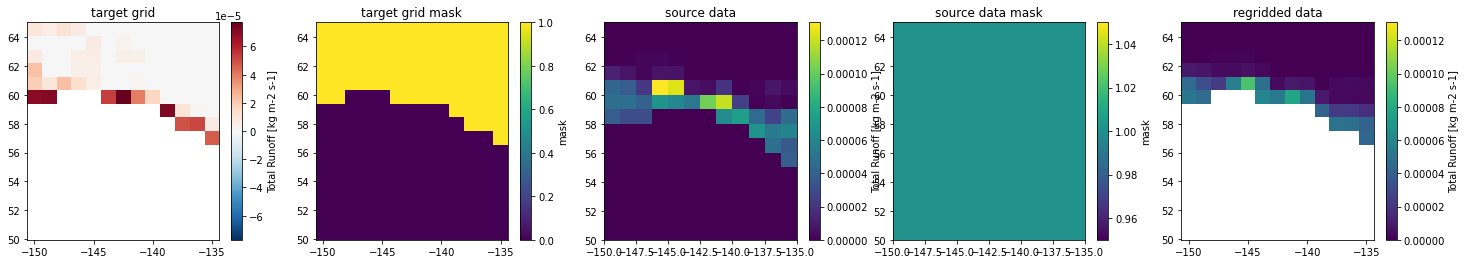

TaiESM1:


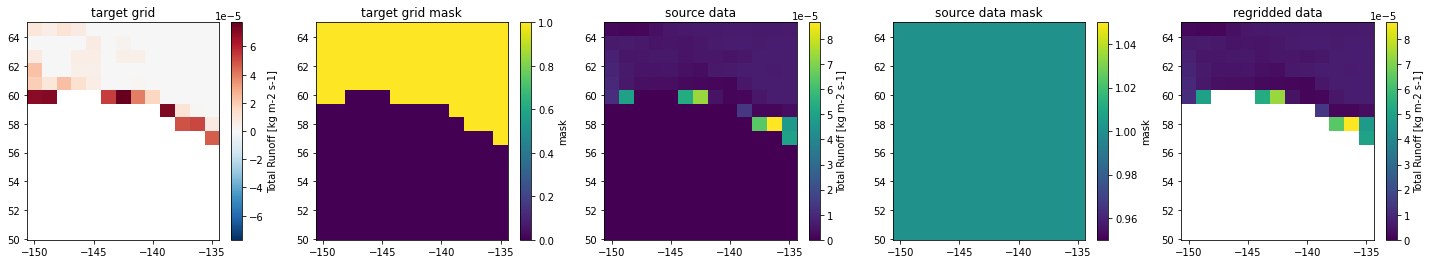

NorESM2-MM:


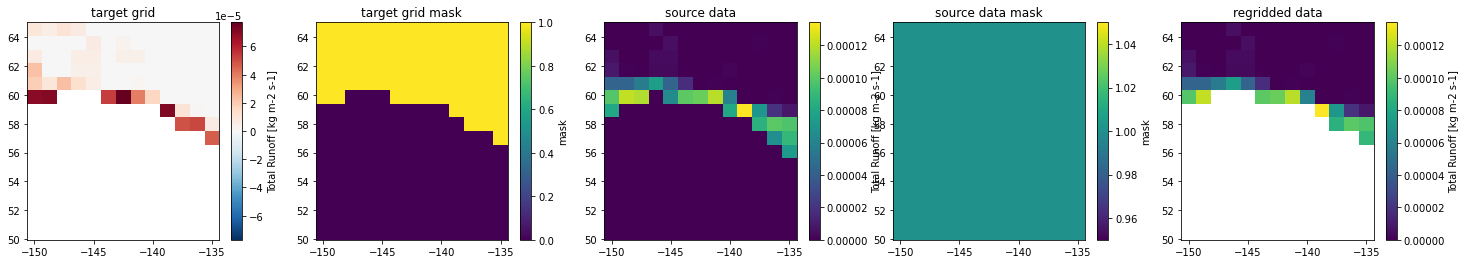

In [7]:
for model in nan_zero.keys():
    src_ds = load_ds(nan_zero[model])
    print(f"{model}:")
    regrid_and_plot(target_ds, src_ds, "mrro", lat_slice, lon_slice)

### Scenario 3:
Source datasets on grids that use Nan as NaN, but do not use the target grid. Here, the NaN values of target grid may "overrule" the values in the source dataset and/or exist inland of the target grid land mask. The source dataset is cropped in some places, while the NaN values are treated as actual values in other places and propagate into the regridded land area.

**This is unsafe; NaN values inland of the target grid land mask are included in regridding math. Some real values are removed during regridding. The regridded output will not have the same land mask as the target grid.**

CNRM-CM6-1-HR:


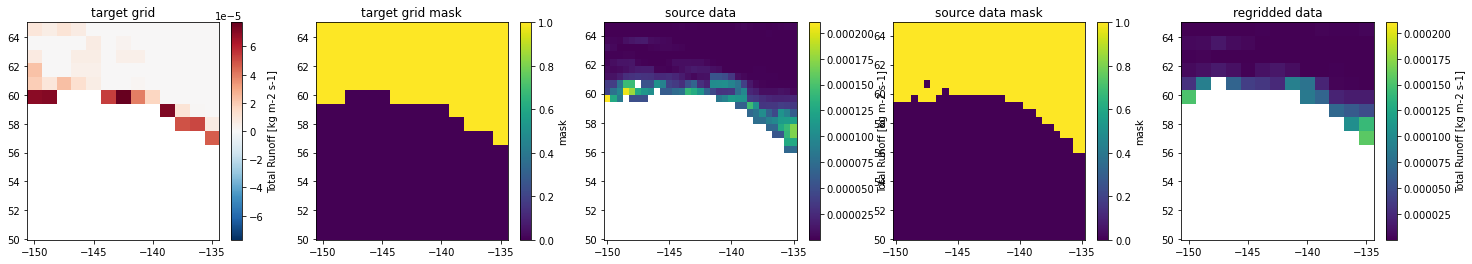

MPI-ESM1-2-HR:


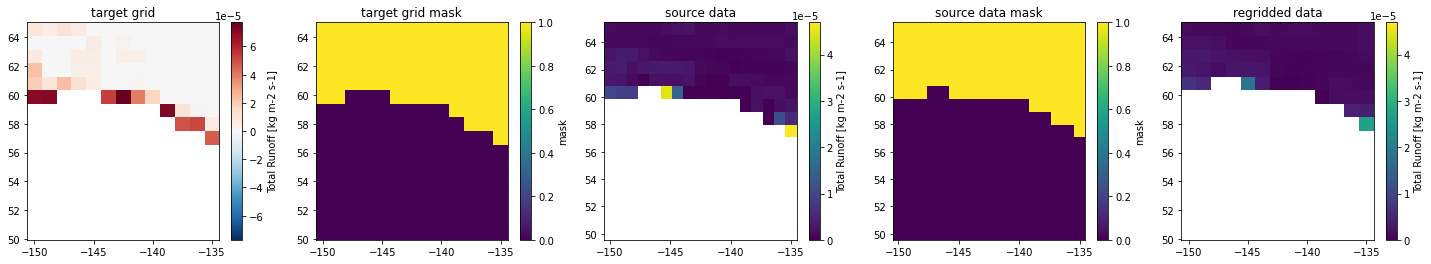

EC-Earth3-Veg:


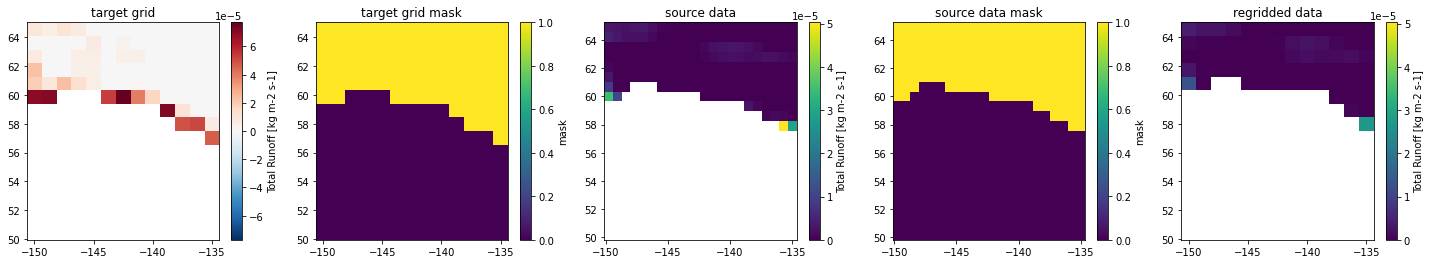

MIROC6:


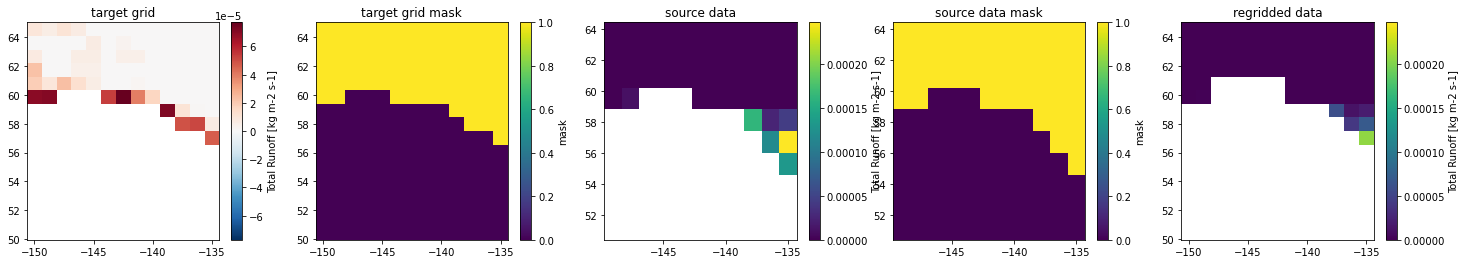

HadGEM3-GC31-LL:


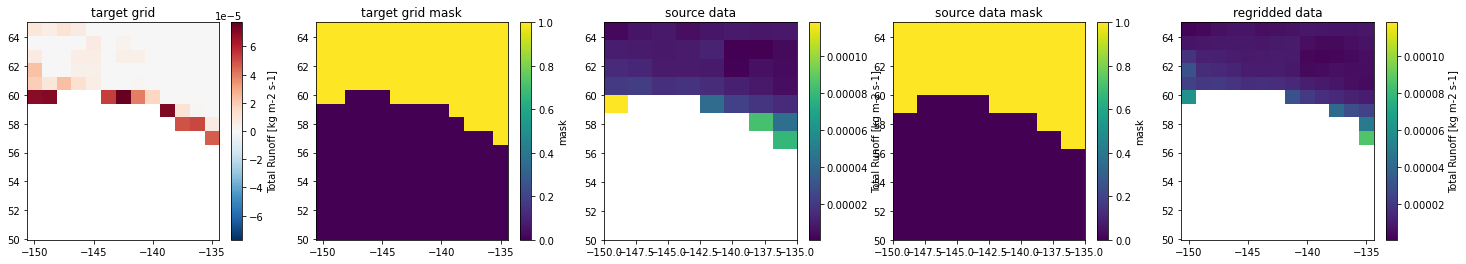

MPI-ESM1-2-LR:


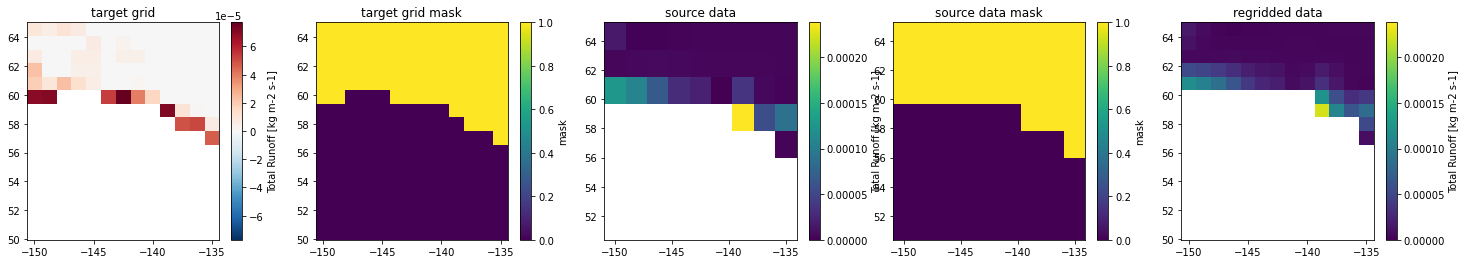

KACE-1-0-G:


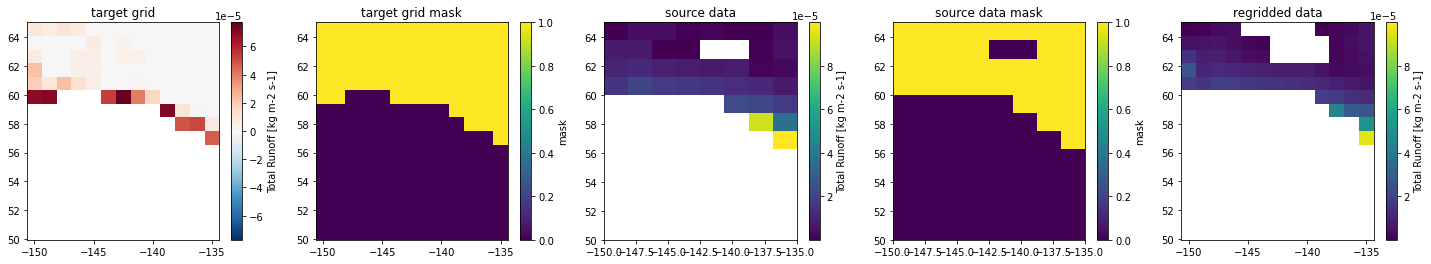

In [8]:
for model in nan_nan.keys():
    src_ds = load_ds(nan_nan[model])
    print(f"{model}:")
    regrid_and_plot(target_ds, src_ds, "mrro", lat_slice, lon_slice)

### Scenario 3 with extrapolation:
Let's try the same thing, but this time include the option for extrapolation when creating the `xESMF.Regridder()`.

We can see in the plots that the regridded outputs now exactly match the target grid land mask, with any inland NaN values filled in by the extrapolation. 

**This is probably the best way to ensure that all regridded outputs have data values for the same grid coordinates, and have NaN values for the same grid coordinates.**

And using extrapolation should not affect the regridded outputs in Scenario 1 or 2, since those scenarios do not have inland NaN values to fill.

CNRM-CM6-1-HR:


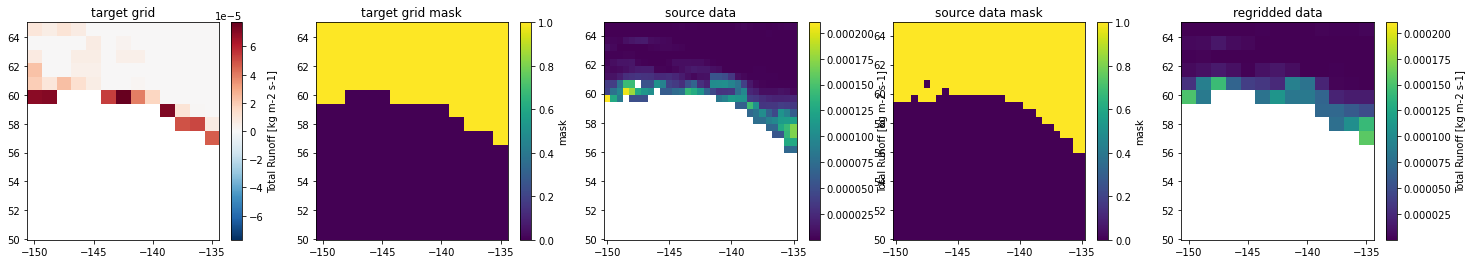

MPI-ESM1-2-HR:


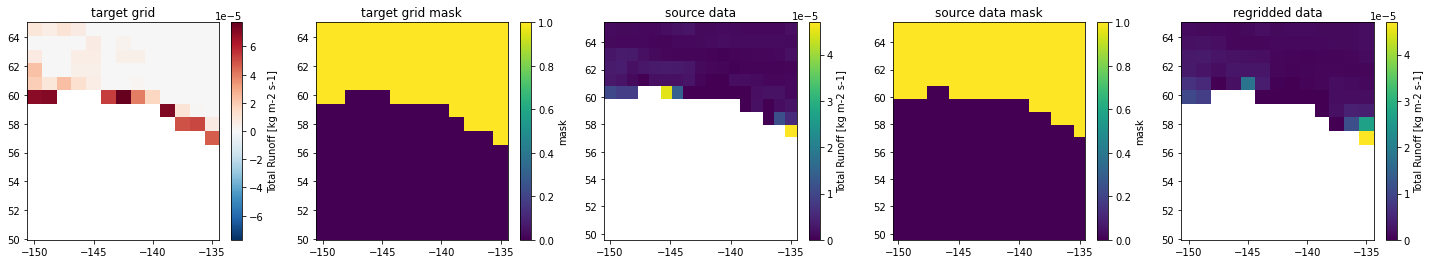

EC-Earth3-Veg:


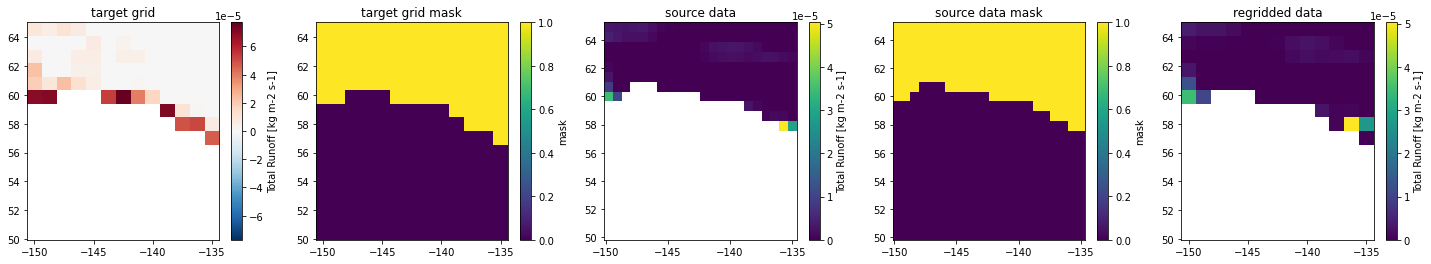

MIROC6:


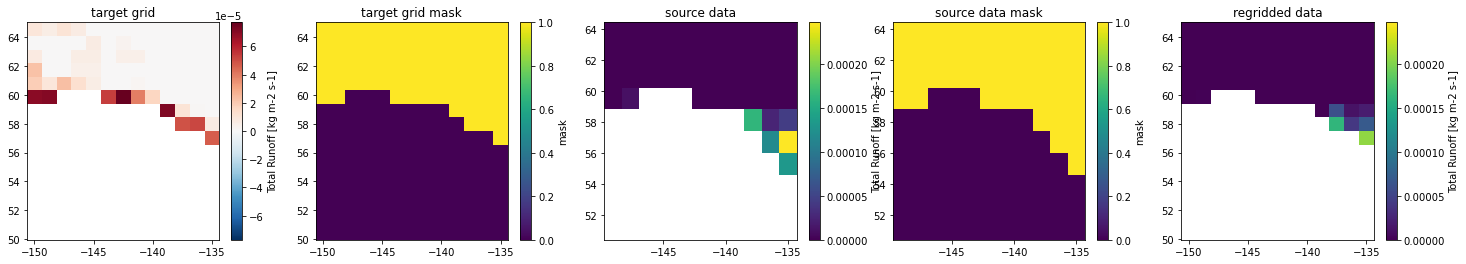

HadGEM3-GC31-LL:


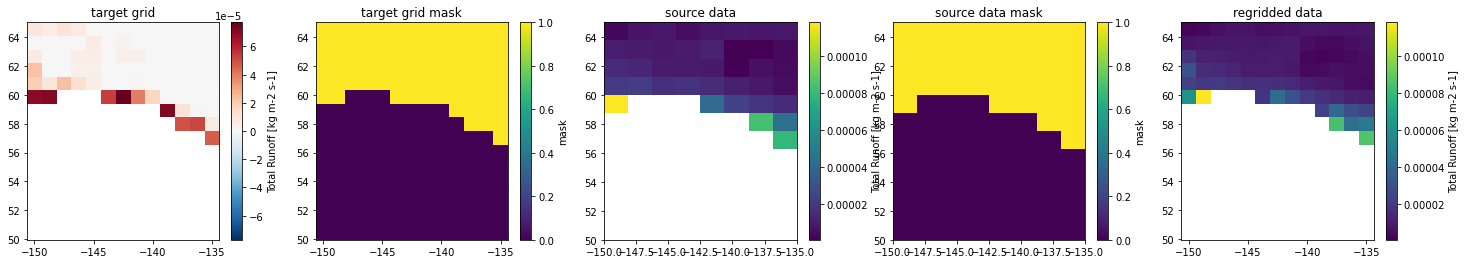

MPI-ESM1-2-LR:


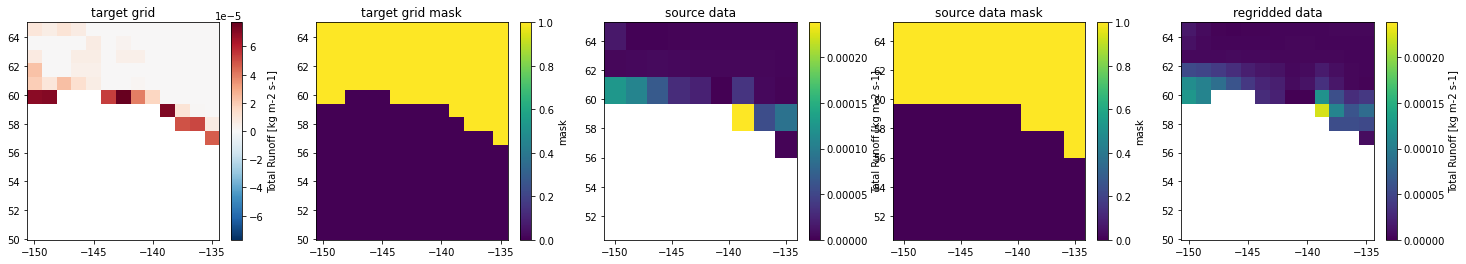

KACE-1-0-G:


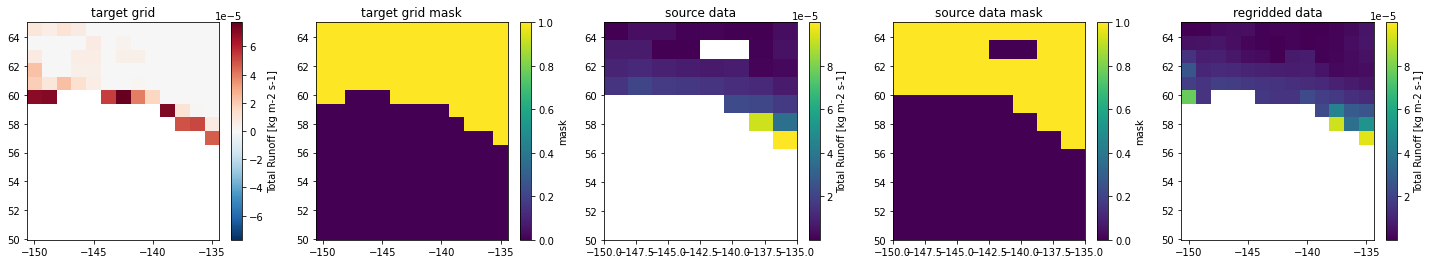

In [9]:
for model in nan_nan.keys():
    src_ds = load_ds(nan_nan[model])
    print(f"{model}:")
    regrid_extrap_and_plot(target_ds, src_ds, "mrro", lat_slice, lon_slice)

## Sea Masks

Now load an NCAR target grid from a sea-only variable `tos`. Then we can plot the data elements of the `xESMF.Regridder()` function to get a sense of what is actually happening with the masks in different grid scenarios.

In [10]:
# target_var_id = "tos"
# target_ds = load_ds('/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/Omon/tos/gn/v20190815/tos_Omon_CESM2-WACCM_ssp370_r1i1p1f1_gn_201501-206412.nc')